<a href="https://colab.research.google.com/github/JoseFPortoles/Segnet-in-Keras/blob/master/U_Net_Xception_style_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SEMANTIC SEGMENTATION USING A U-Net Xception STYLE MODEL
The U-Net Xception-style model is adapted from F. Chollet's [Image segmentation with a U-Net-like architecture](https://keras.io/examples/vision/oxford_pets_image_segmentation/) keras code example.

In the present notebook training for segmentation is attempted on the PASCAL VOC 2009 dataset for 22 categories (20 object categories + Border + Background).

Another difference is the implementation of data augmentation using the [Imgaug package](https://imgaug.readthedocs.io/en/latest/#)

## SET MAIN VARIABLES

In [ ]:
import numpy as np
#from tensorflow import keras
#from tensorflow.keras import models
#from tensorflow.keras.models import Model
#from tensorflow.keras.layers import *
#from tensorflow.keras import Input

#Variables
x_imsize = 224
y_imsize = 224
img_size = (x_imsize,y_imsize)
num_classes = 22
batch_size = 32
epochs = 20

voc_root_folder = "./VOCdevkit/VOC2009"

## DATASET ARRANGEMENT

### Fetch Data

In [ ]:
!wget -nc http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar

#Decompress from home directory 
!tar -xf VOCtrainval_11-May-2009.tar --totals

--2020-09-03 17:38:34--  http://host.robots.ox.ac.uk/pascal/VOC/voc2009/VOCtrainval_11-May-2009.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 935534080 (892M) [application/x-tar]
Saving to: ‘VOCtrainval_11-May-2009.tar’

VOCtrainval_11-May- 100%[===================>] 892.19M  8.71MB/s    in 1m 43s  

2020-09-03 17:40:17 (8.66 MB/s) - ‘VOCtrainval_11-May-2009.tar’ saved [935534080/935534080]

Total bytes read: 935536640 (893MiB, 247MiB/s)


### Create directory tree

In [ ]:
import os, shutil

#START PATHS
base_path = voc_root_folder
img_start_path = os.path.join(base_path, 'JPEGImages')
mask_start_path = os.path.join(base_path, 'SegmentationClass')
train_list_path = os.path.join(base_path, 'ImageSets/Segmentation/train.txt')
trainval_list_path = os.path.join(base_path, 'ImageSets/Segmentation/trainval.txt')
val_list_path = os.path.join(base_path, 'ImageSets/Segmentation/val.txt')

#END PATHS
train_end_path = './dataset/segmentation/train'
train_mask_end_path = './dataset/segmentation/train_masks'
trainval_end_path = './dataset/segmentation/trainval'
trainval_mask_end_path = './dataset/segmentation/trainval_masks'
val_end_path = './dataset/segmentation/val'
val_mask_end_path = './dataset/segmentation/val_masks'

def copy_segmentation_files(list_path, start_path, end_path):
    #CLEAR/CREATE END FOLDERS
    shutil.rmtree(end_path, ignore_errors=True)
    os.makedirs(end_path, exist_ok=True)
    
    startlist = os.listdir(start_path)
    ext = startlist[0][-4:]
    #READ SEGMENTATION TRAINSET LIST AND COPY FILES
    f = open(list_path, "r")
    for line in f:
        print(str(os.path.isfile(os.path.join(start_path, line[:-1] + ext)))+': '+os.path.join(start_path, line[:-1] + ext))
        if os.path.isfile(os.path.join(start_path, line[:-1] + ext)):
            shutil.copy(os.path.join(start_path, line[:-1] + ext), end_path)
    f.close()
    
#COPY IMAGES AND MASKS FROM START PATHS TO END PATHS

copy_segmentation_files(train_list_path, img_start_path, train_end_path)
copy_segmentation_files(train_list_path, mask_start_path, train_mask_end_path)
copy_segmentation_files(trainval_list_path, img_start_path, trainval_end_path)
copy_segmentation_files(trainval_list_path, mask_start_path, trainval_mask_end_path)
copy_segmentation_files(val_list_path, img_start_path, val_end_path)
copy_segmentation_files(val_list_path, mask_start_path, val_mask_end_path)

Se han truncado las últimas 5000 líneas del flujo de salida.
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008072.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008085.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008140.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008142.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008203.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008218.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008219.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008307.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008403.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008407.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008468.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008526.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008571.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008575.png
True: ./VOCdevkit/VOC2009/SegmentationClass/2007_008714.png
True: ./VOCdevkit/VOC2009/SegmentationC

### Create path lists

In [ ]:
train_input_dir = train_end_path
train_target_dir = train_mask_end_path
val_input_dir = val_end_path
val_target_dir = val_mask_end_path

train_input_paths = sorted(
    [
        os.path.join(train_input_dir, fname)
        for fname in os.listdir(train_input_dir)
        if fname.endswith(".jpg")
    ]
)
train_target_paths = sorted(
    [
        os.path.join(train_target_dir, fname)
        for fname in os.listdir(train_target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

val_input_paths = sorted(
    [
        os.path.join(val_input_dir, fname)
        for fname in os.listdir(val_input_dir)
        if fname.endswith(".jpg")
    ]
)
val_target_paths = sorted(
    [
        os.path.join(val_target_dir, fname)
        for fname in os.listdir(val_target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

#Sanity check
print('Nr of train images: ' + str(len(os.listdir(train_end_path))) + '\n')
print('Nr of train masks: ' + str(len(os.listdir(train_mask_end_path))) + '\n')
print('Nr of train/validation images: ' + str(len(os.listdir(trainval_end_path))) + '\n')
print('Nr of train/validation masks: ' + str(len(os.listdir(trainval_mask_end_path))) + '\n')
print('Nr of validation images: ' + str(len(os.listdir(val_end_path))) + '\n')
print('Nr of validation masks: ' + str(len(os.listdir(val_mask_end_path))) + '\n')

Nr of train images: 749

Nr of train masks: 749

Nr of train/validation images: 1499

Nr of train/validation masks: 1499

Nr of validation images: 750

Nr of validation masks: 750



## MODEL CREATION

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

### Load a saved model:
Uncomment if loading of a pre-saved model is needed at this point.

In [ ]:
#from tensorflow import keras
#model_path = './voc2009_segmentation.h5'
#model_path ='/content/drive/My Drive/VOCSegment_ImageNetVGG16_22cat_100epochs(colab).h5'
#model = keras.models.load_model(model_path)

## DATA GENERATION



### Data generator class
Here I use the Sequence class from Keras instead of ImageDataGenerator. This is in order to produce customised masks that allow to:
* Either work with the 20 original Pascal-VOC-2009 object categories or to define broader categories. This is done through a for-loop that goes through each pixel of the original mask modifying the values of selected categories. 
* Ensure that the pixel value for the border regions is a consecutive integer to the object categories.
* Produce one-hot-encoding masks to be used during training with in conjunction with the categorical crossentropy loss function. 
* Resize the mask to fit the dimensions of the model's output, in case the model happened to change the resolution of the input images.

The main disadvantage of this approach is perhaps having to implement data augmentation, as it is not built in the Sequence class. This would be my next step should I have more time. I would probably use a preexisting dedicated library such as albumentations (https://github.com/albumentations-team/albumentations) or imgaug (https://github.com/aleju/imgaug)



#### 20 VOC-2009 Categories
This data generator generates masks with the original values with the exception of border pixels (value = 255) that are converted to 21 and so counted as an extra category. Therefore:
  * 0: Background pixels
  * 1-20: VOC 2009 object categories
  * 21: Border regions

In [42]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapOnImage
import PIL
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

class VOC2009SegData(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, num_classes, img_size, mask_size, input_img_paths, target_img_paths, augmentation=False):
        self.batch_size = batch_size
        self.num_classes = num_classes
        self.img_size = img_size
        self.mask_size = mask_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.seq = iaa.Sequential(
            [
             iaa.Fliplr(0.5),  
             iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
             iaa.ContrastNormalization((0.75, 1.5)),
             #iaa.AdditiveGaussianNoise(
             #    loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
             #iaa.Multiply((0.8, 1.2), per_channel=0.2),
             iaa.Affine(
                 scale={
                     "x": (0.8, 1.2),
                     "y": (0.8, 1.2)
                },
                translate_percent={
                    "x": (-0.2, 0.2),
                    "y": (-0.2, 0.2)
                },
                rotate=(-25, 25),
                shear=(-8, 8)
                )
             ],
             random_order=True)
        self.augmentation = augmentation

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) corresponding to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((batch_size,) + self.mask_size + (self.num_classes,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            #Resize image
            msk = PIL.Image.open(path)
            msk = msk.resize(self.mask_size, resample=PIL.Image.NEAREST)
            msk = np.array(msk,dtype="uint8")
            
            #Object borders become category 21
            msk = np.where(msk==255, 21, msk)
            
            # One-hot encoding
            msk = to_categorical(msk, num_classes=self.num_classes)
            
            # Augmentation
            if self.augmentation:
              msk = SegmentationMapOnImage(msk, shape=x[j].shape)
              aug_img, aug_msk = self.seq(image=x[j], segmentation_maps=msk)
              x[j] = aug_img
              y[j] = aug_msk.arr 
            else:
              y[j] = msk
        return x, y



#Shape of the model output (to resize mask to size)
mask_size = tuple(model.layers[-1].output.shape[1:3])

# Instantiate data generators for each split

train_gen = VOC2009SegData(
    batch_size,
    num_classes,
    img_size,
    mask_size,
    train_input_paths, 
    train_target_paths, 
    augmentation=True
)

val_gen = VOC2009SegData(
    batch_size, 
    num_classes, 
    img_size, 
    mask_size, 
    val_input_paths, 
    val_target_paths, 
    augmentation=False)


## TRAIN MODEL 2

In [46]:
# Compile model for training
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import CategoricalCrossentropy

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4, momentum=0.9), 
    loss="categorical_crossentropy", 
    #metrics=[MeanIoU(num_classes=num_classes)]
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "U-Net-Xception_Segmentation.h5",
        monitor = 'val_loss',
        save_best_only=True,
        ),
    keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
       patience = 5,
    )
]

# Train the model, doing validation at the end of each epoch.
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/20
23/23 [==============================] - 34s 1s/step - loss: 0.8695 - val_loss: 1.1739
Epoch 2/20
23/23 [==============================] - 33s 1s/step - loss: 0.8609 - val_loss: 1.1534
Epoch 3/20
23/23 [==============================] - 33s 1s/step - loss: 0.8410 - val_loss: 1.1452
Epoch 4/20
23/23 [==============================] - 33s 1s/step - loss: 0.8413 - val_loss: 1.1553
Epoch 5/20
23/23 [==============================] - 33s 1s/step - loss: 0.8277 - val_loss: 1.1412
Epoch 6/20
23/23 [==============================] - 33s 1s/step - loss: 0.8086 - val_loss: 1.1345
Epoch 7/20
23/23 [==============================] - 33s 1s/step - loss: 0.8154 - val_loss: 1.1461
Epoch 8/20
23/23 [==============================] - 33s 1s/step - loss: 0.8059 - val_loss: 1.1494
Epoch 9/20
23/23 [==============================] - 33s 1s/step - loss: 0.7987 - val_loss: 1.1252
Epoch 10/20
23/23 [==============================] - 32s 1s/step - loss: 0.7956 - val_loss: 1.1565
Epoch 11/20
23/23 [

## VISUALISE PREDICTIONS MODEL2
In this part segmentation mask are predicted from a set of validation set pictures: For each picture it displays the original picture followed by ground truth mask and that followed by predicted mask. It also prints a list of the object categories found on the ground truth followed by the same list for the predicted masks.



In [ ]:
#VOC 2009
test_gen = VOC2009SegData(5, num_classes, img_size, mask_size, val_input_paths, val_target_paths, augmentation =True)
x = test_gen[0]
test_predicts = model.predict([x[0]])

In [39]:
import matplotlib.pyplot as plt
#from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

def disp_mask(img_array):
  flatmask = np.argmax(img_array, axis=2)
  print(flatmask.dtype)
  print(flatmask.shape)
  print(np.unique(flatmask))
  plt.figure(figsize=(5, 5))
  plt.imshow(flatmask)
  plt.axis('off')
  plt.show()


GT masks uniques: [0 1]
GT masks histogram: (array([34136561,        0,        0,        0,        0,        0,
              0,        0,        0,  1187343]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))
GT masks shape: (32, 224, 224, 22)
GT masks type: uint8
Predicted masks uniques: [0. 1.]
Predicted histogram: (array([33832971,        0,        0,        0,        0,        0,
              0,        0,        0,  1490933]), array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
      dtype=float32))
Predicted masks shape: (32, 224, 224, 22)
Predicted masks type: float32
float32
int64
(224, 224)
[ 0  1 15 21]


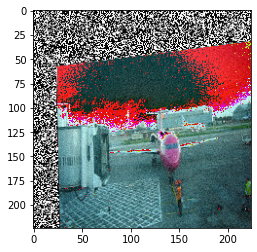

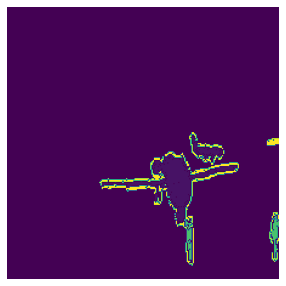

int64
(224, 224)
[ 0  1  4 21]


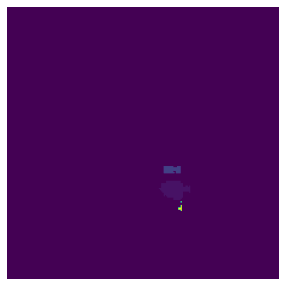

int64
(224, 224)
[ 0 20 21]


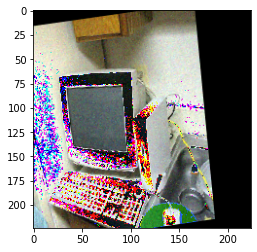

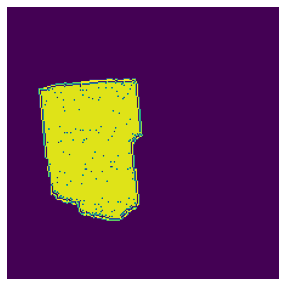

int64
(224, 224)
[ 0 20]


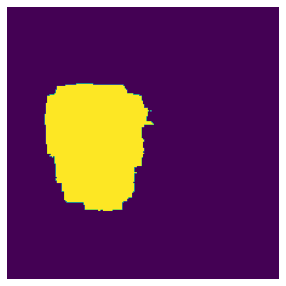

int64
(224, 224)
[ 0  9 12 21]


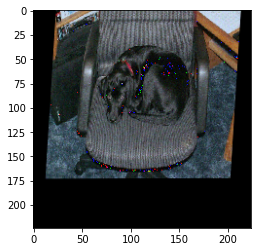

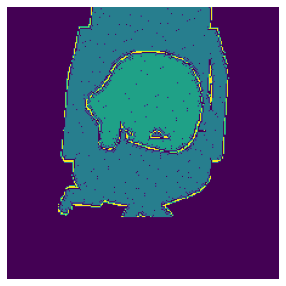

int64
(224, 224)
[ 0  9 12 15 20]


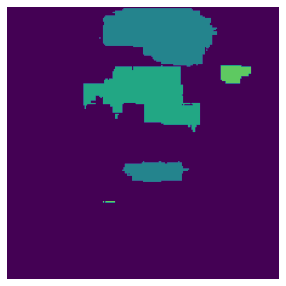

int64
(224, 224)
[ 0  3 21]


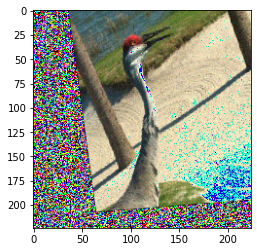

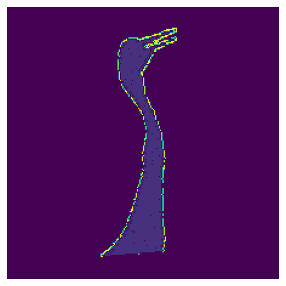

int64
(224, 224)
[0 3 8]


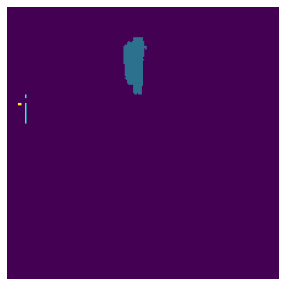

int64
(224, 224)
[ 0 20 21]


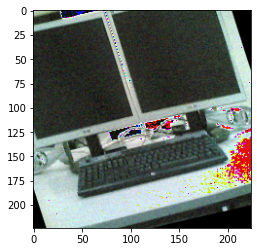

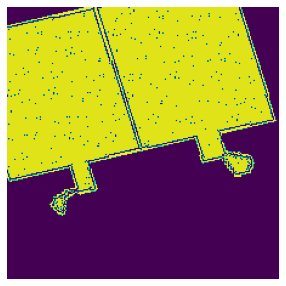

int64
(224, 224)
[ 0 20]


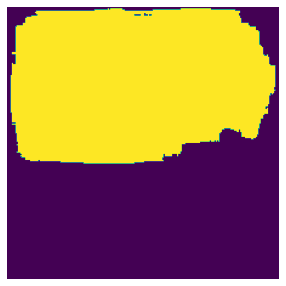

int64
(224, 224)
[ 0  5 15 21]


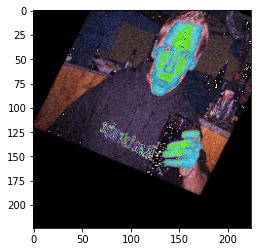

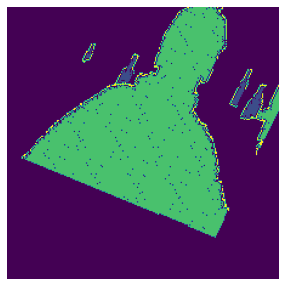

int64
(224, 224)
[ 0 15]


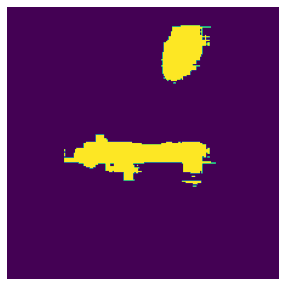

int64
(224, 224)
[ 0  4 21]


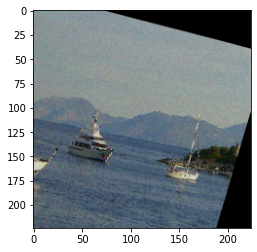

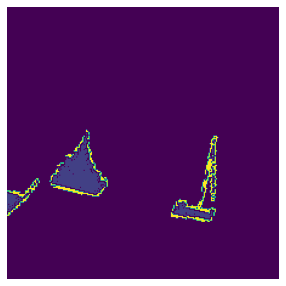

int64
(224, 224)
[ 0  4 21]


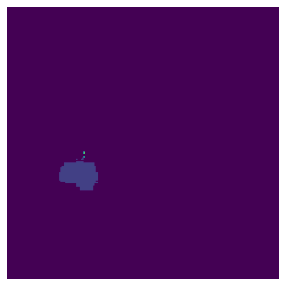

int64
(224, 224)
[ 0  1 21]


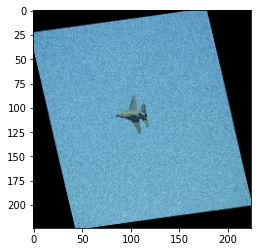

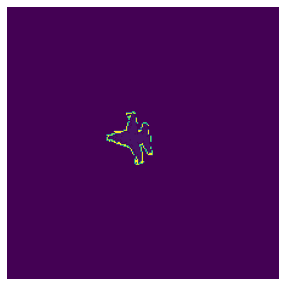

int64
(224, 224)
[ 0  1  3 21]


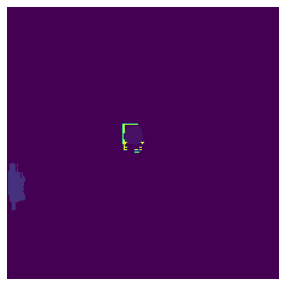

int64
(224, 224)
[ 0  5 11 21]


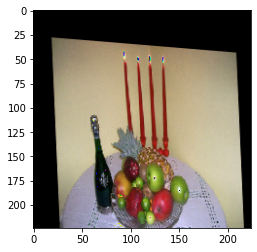

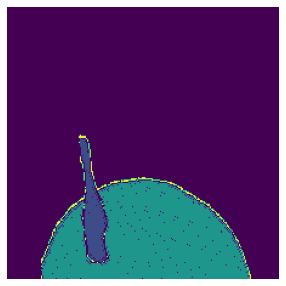

int64
(224, 224)
[ 0 11]


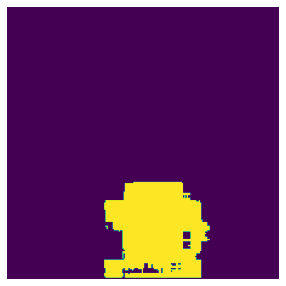

int64
(224, 224)
[ 0  1 21]


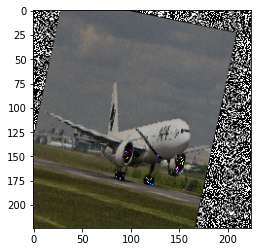

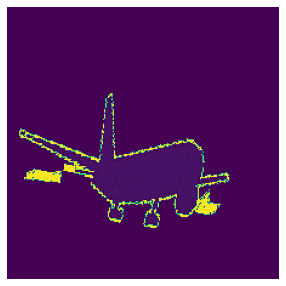

int64
(224, 224)
[0 1]


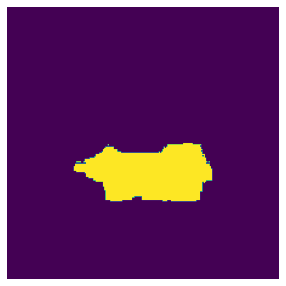

int64
(224, 224)
[ 0 19 21]


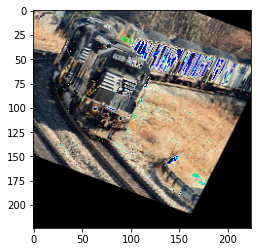

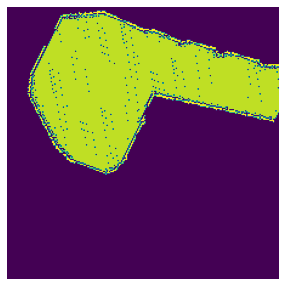

int64
(224, 224)
[ 0 19]


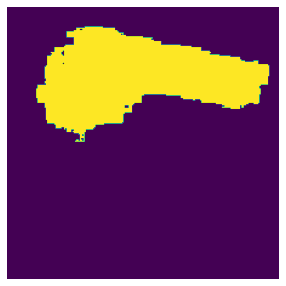

int64
(224, 224)
[ 0  3 21]


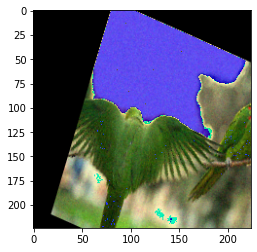

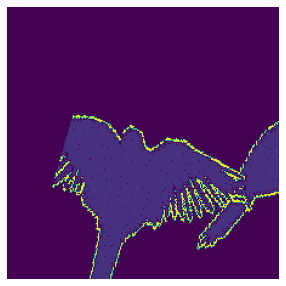

int64
(224, 224)
[ 0  3  8 16]


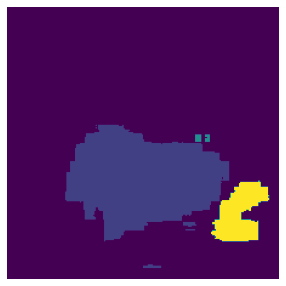

int64
(224, 224)
[ 0 14 15 21]


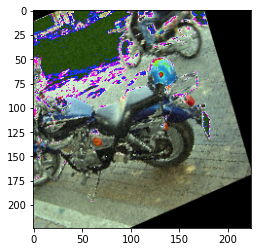

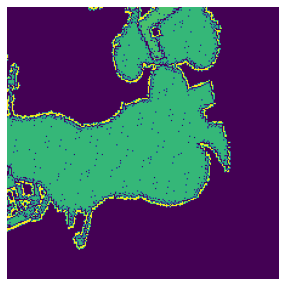

int64
(224, 224)
[ 0 14]


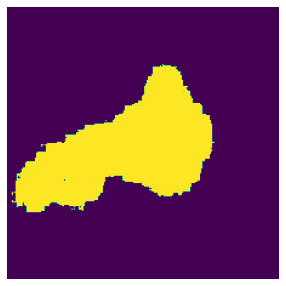

int64
(224, 224)
[ 0 13 15 21]


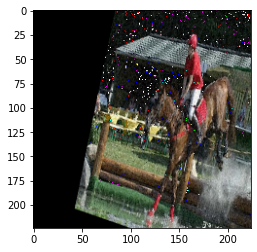

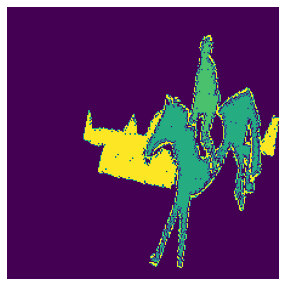

int64
(224, 224)
[ 0 13]


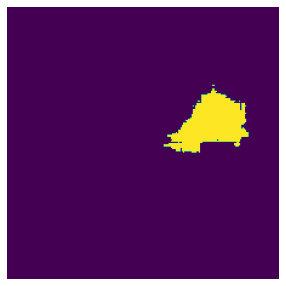

int64
(224, 224)
[ 0  1 15 21]


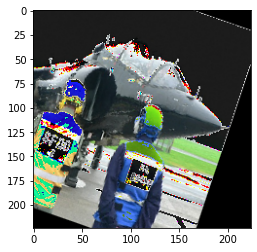

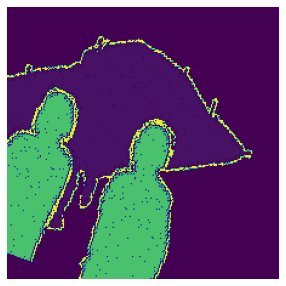

int64
(224, 224)
[ 0  1  6  7 15]


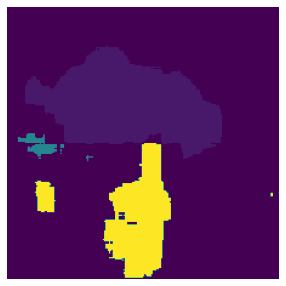

int64
(224, 224)
[ 0 10 15 21]


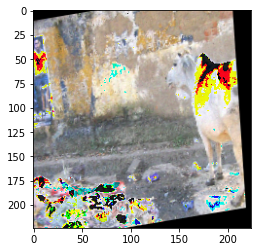

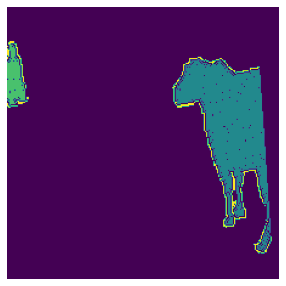

int64
(224, 224)
[ 0 10 13 17]


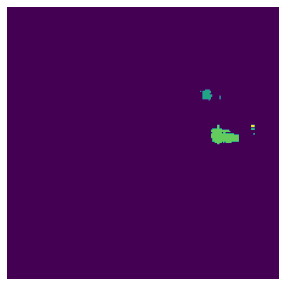

int64
(224, 224)
[ 0  2  7 15 21]


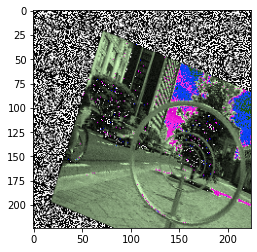

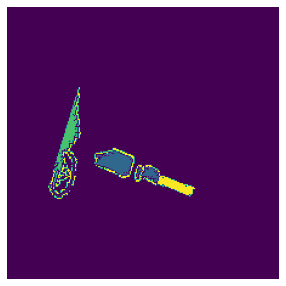

int64
(224, 224)
[0]


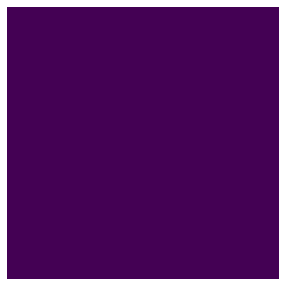

int64
(224, 224)
[ 0  8 21]


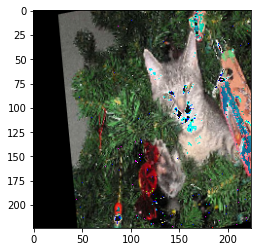

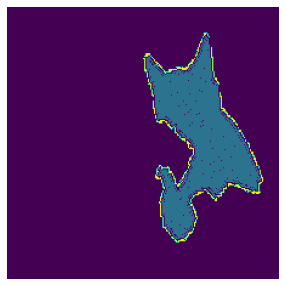

int64
(224, 224)
[ 0 12 15 16]


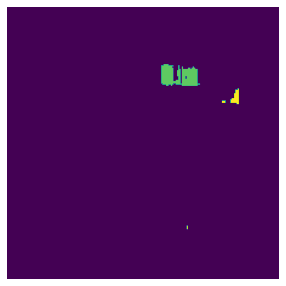

int64
(224, 224)
[ 0  8 21]


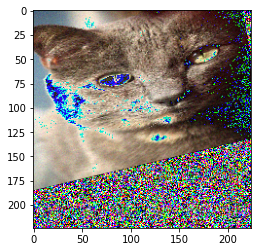

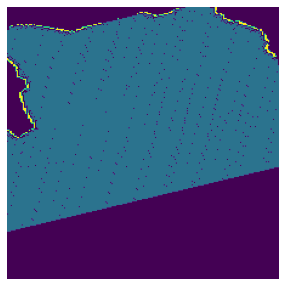

int64
(224, 224)
[0 8]


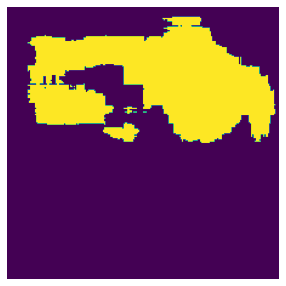

int64
(224, 224)
[ 0  2 18 21]


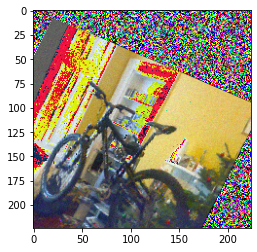

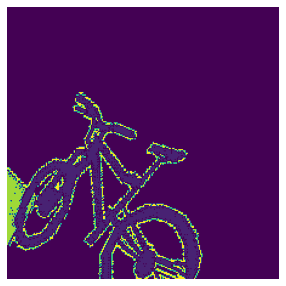

int64
(224, 224)
[ 0 10 14]


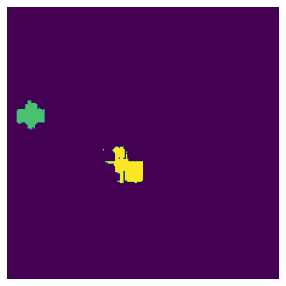

int64
(224, 224)
[ 0  3 21]


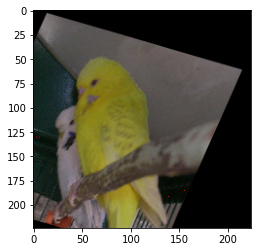

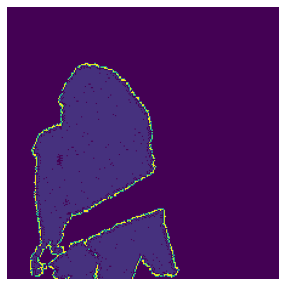

int64
(224, 224)
[0 3]


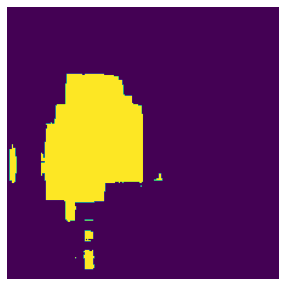

int64
(224, 224)
[ 0  1  6 15 21]


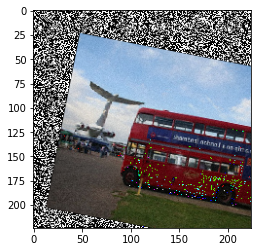

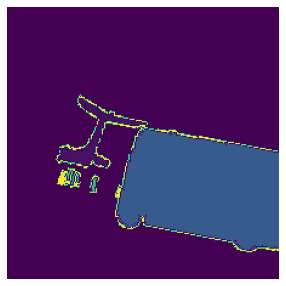

int64
(224, 224)
[0 1 6]


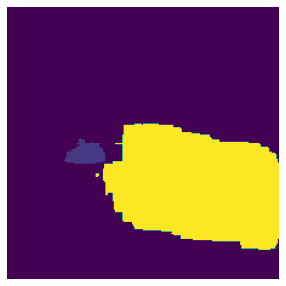

int64
(224, 224)
[ 0  4 21]


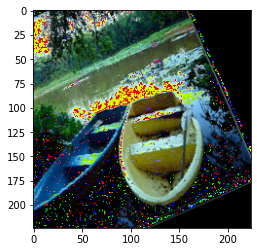

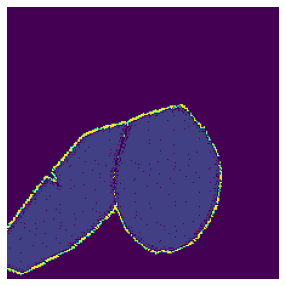

int64
(224, 224)
[0 4 6]


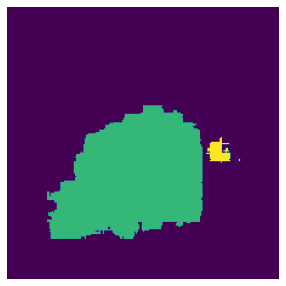

int64
(224, 224)
[ 0 12 21]


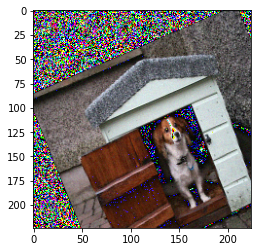

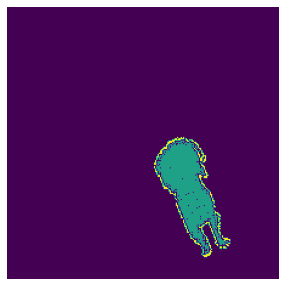

int64
(224, 224)
[ 0 12]


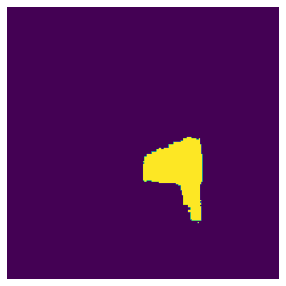

int64
(224, 224)
[ 0 14 15 21]


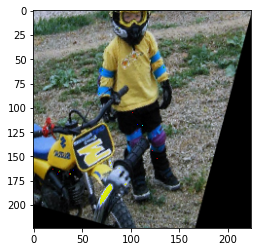

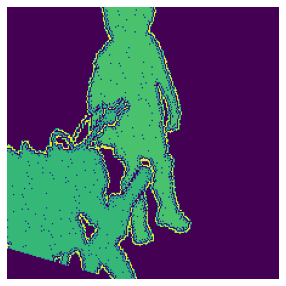

int64
(224, 224)
[ 0 14 15]


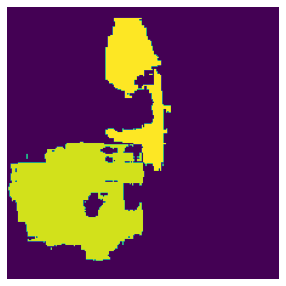

int64
(224, 224)
[ 0  1 21]


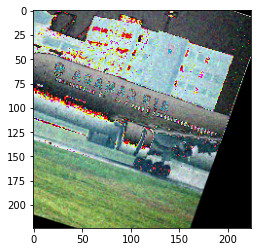

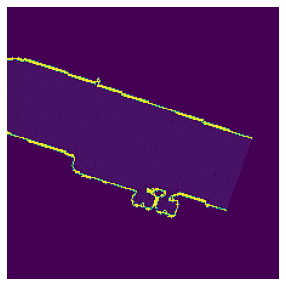

int64
(224, 224)
[0 1 4]


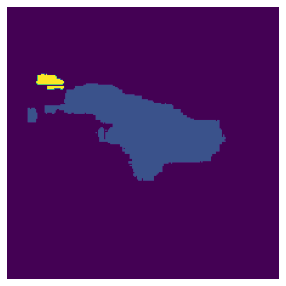

int64
(224, 224)
[ 0  6 21]


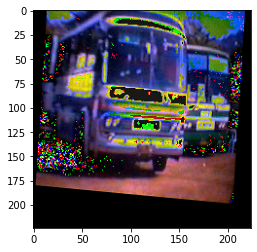

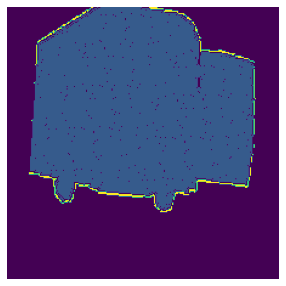

int64
(224, 224)
[0 6 7]


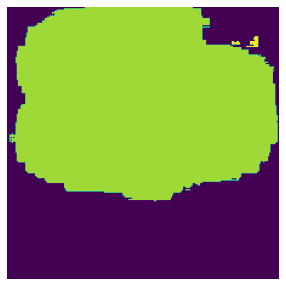

int64
(224, 224)
[ 0  2  6 15 21]


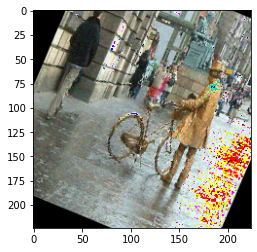

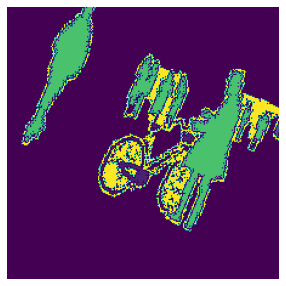

int64
(224, 224)
[ 0 11 15]


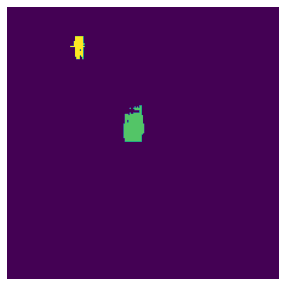

int64
(224, 224)
[ 0 14 21]


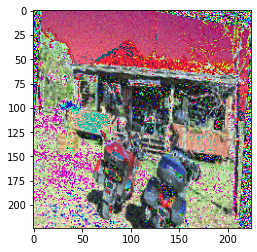

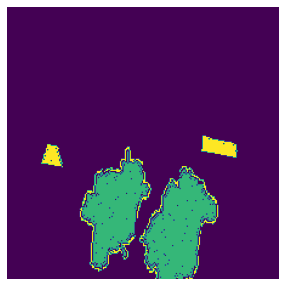

int64
(224, 224)
[ 0 14 15]


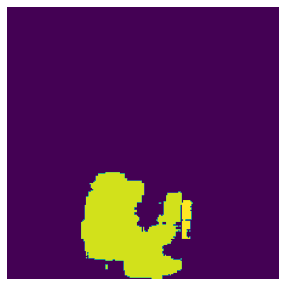

int64
(224, 224)
[ 0 13 15 21]


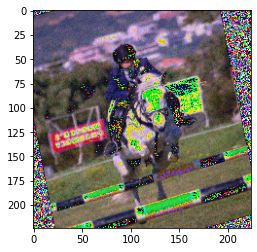

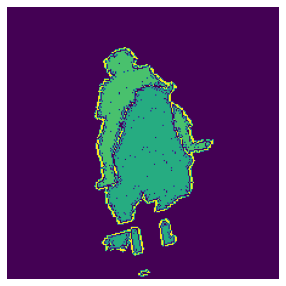

int64
(224, 224)
[ 0  6 12 13 15]


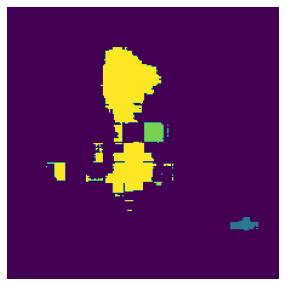

int64
(224, 224)
[ 0  8 21]


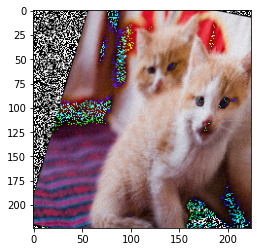

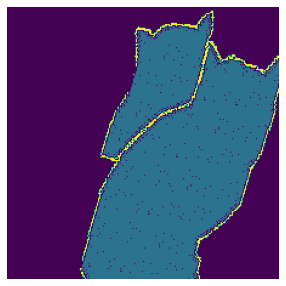

int64
(224, 224)
[ 0  8 15]


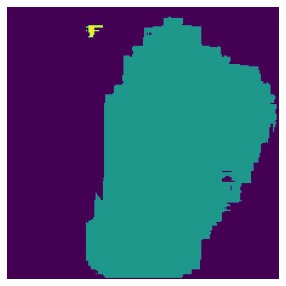

In [40]:
data_batch = train_gen[0]
image_batch = data_batch[0].astype(np.uint8)
mask_batch = data_batch[1]
est_predicts = np.rint(model.predict(data_batch))
print("GT masks uniques: " + str(np.unique(mask_batch)))
print("GT masks histogram: " + str(np.histogram(mask_batch)))
print("GT masks shape: " + str(mask_batch.shape))
print("GT masks type: " + str(mask_batch.dtype))
print("Predicted masks uniques: " + str(np.unique(est_predicts)))
print("Predicted histogram: " + str(np.histogram(est_predicts)))
print("Predicted masks shape: " + str(est_predicts.shape))
print("Predicted masks type: " + str(est_predicts.dtype))
print(est_predicts.dtype)
for n in range(0,31):
  plt.imshow(image_batch[n])
  disp_mask(mask_batch[n])
  disp_mask(est_predicts[n])
